#### load python packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import flopy
from flopy.plot import styles
import os
import shutil

In [2]:
import pandas as pd

#### specify folder location of modflow 6 model files created by converter, and new folder to place a copy of the files that we will use here

In [3]:
orig_dir = os.path.join("data", "mumodel_mf6")
tpl_dir = os.path.join("data", "mumodel_tpl")
if os.path.exists(tpl_dir):
    shutil.rmtree(tpl_dir)
shutil.copytree(orig_dir, tpl_dir)

'data\\mumodel_tpl'

#### instantiate a flopy model object from the files copied to the new folder

In [4]:
name = "mumodel"
exe_name = "mf6"
sim = flopy.mf6.MFSimulation.load(sim_ws=tpl_dir)
m = sim.get_model(name)
mg = m.modelgrid

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package dis...
    loading package ic...
    loading package npf...
    loading package sto...
    loading package oc...
    loading package wel...
    loading package rch...
    loading package chd...
  loading solution package mumodel...


#### specify a coordinate refernce system for the model using the modelgrid object

In [5]:
mg.set_coord_info(crs="epsg:26912")

In [6]:
mg

xll:0.0; yll:0.0; rotation:0.0; crs:EPSG:26912; units:undefined; lenuni:0

## Create an Observation Package to track simulated heads at two locations: (row 11, column 5), and (row 5, column 5)

In [7]:
flopy.mf6.ModflowUtlobs(m, continuous={"hds.csv": [("hds001_010_004", "HEAD", (0, 10, 4)), ("hds001_004_004", "HEAD", (0, 4, 4))]})

package_name = obs_0
filename = mumodel.obs
package_type = obs
model_or_simulation_package = model
model_name = mumodel

Block continuous
--------------------
continuous
{internal}
(rec.array([('hds001_010_004', 'HEAD', (0, 10, 4), None),
           ('hds001_004_004', 'HEAD', (0, 4, 4), None)],
          dtype=[('obsname', 'O'), ('obstype', 'O'), ('id', 'O'), ('id2', 'O')]))



#### write the MODFLOW 6 model input files and run the model

In [8]:
sim.write_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package mumodel...
  writing model mumodel...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package sto...
    writing package oc...
    writing package wel-1...
    writing package rch-1...
    writing package chd-from-ibound...
    writing package obs_0...


In [9]:
sim.run_simulation()

FloPy is using the following executable to run the model: ..\..\..\..\..\..\A\anaconda3\envs\pyclass\Scripts\mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.4.4 02/13/2024

   MODFLOW 6 compiled Feb 19 2024 14:20:00 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.7.0
                             Build 20220726_000000

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by the USGS or the U.S. Government as to the 
functionality of the software and related material nor shall the 
fact of release constitute any such warranty. Furthermore, the 
software is released on condition that neithe

(True, [])

#### instantiate an object of the saved head outputs (here we are just using a predefined flopy method that finds the binary output file specified in the NAM file and returns the head values)

In [10]:
hds = m.output.head()

#### the get_alldata() method returns a 4 dimensional numpy array (time, layer, row, column) of all saved head values

#### the numpy array object has an associated method that will convert the array into a 1D array of values that can be fed to a histogram plot

(array([ 3474.,     0.,  3482.,    55.,  3505.,  3468.,  3386.,  3474.,
         3474., 12159.]),
 array([1000.        , 1001.09275262, 1002.18550524, 1003.27825786,
        1004.37101048, 1005.4637631 , 1006.55651572, 1007.64926834,
        1008.74202096, 1009.83477359, 1010.92752621]),
 <BarContainer object of 10 artists>)

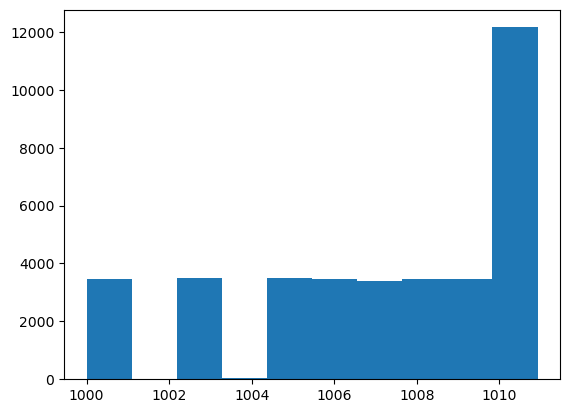

In [11]:
plt.hist(hds.get_alldata().ravel())

#### create a FOR LOOP to cycle through the timesteps for which heads are saved in the head output file and plot a 2D array for each of the simulated time step outputs

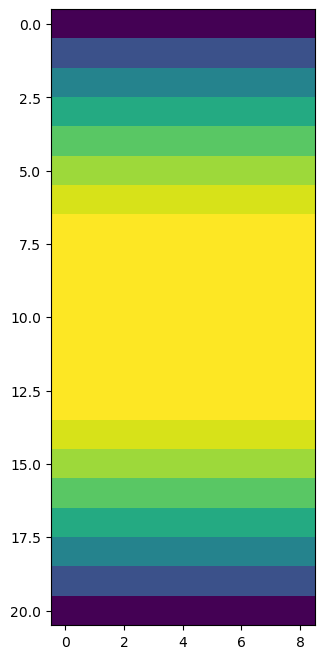

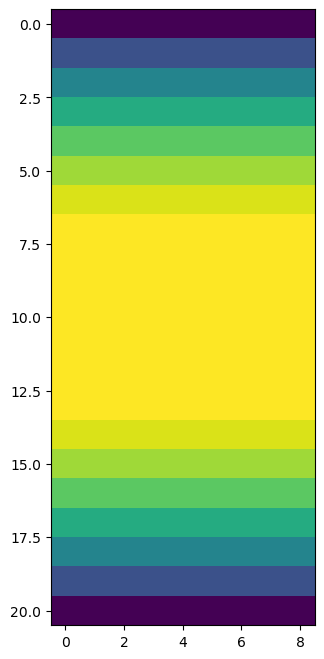

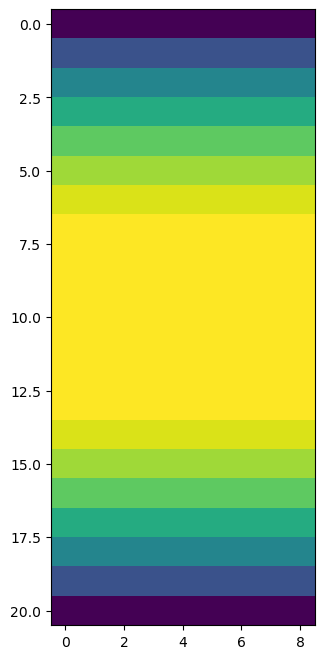

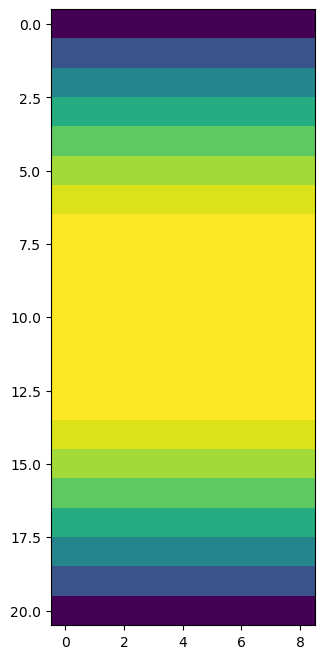

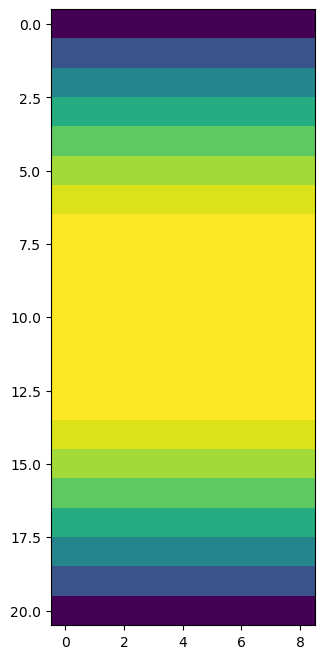

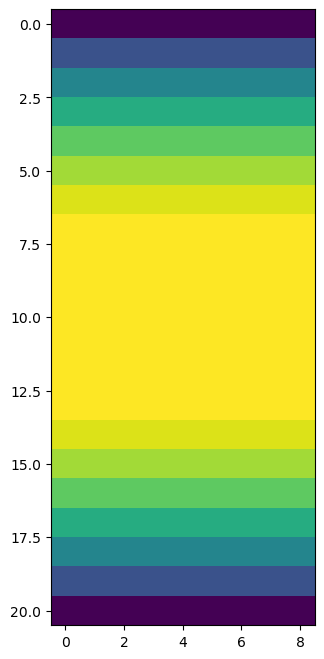

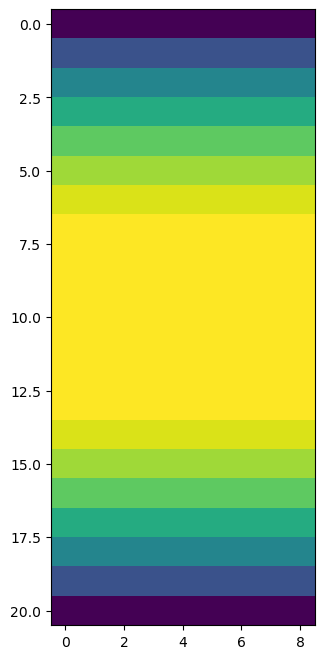

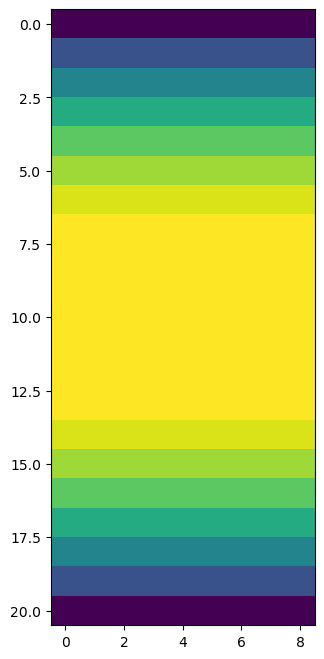

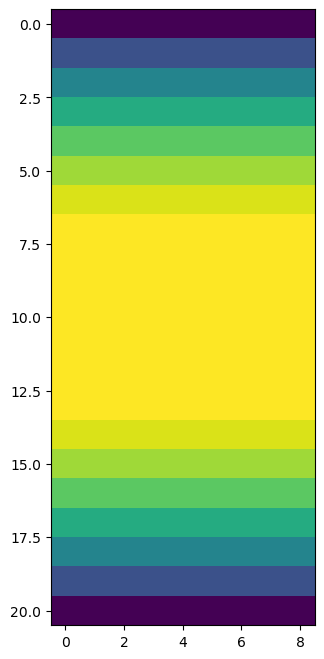

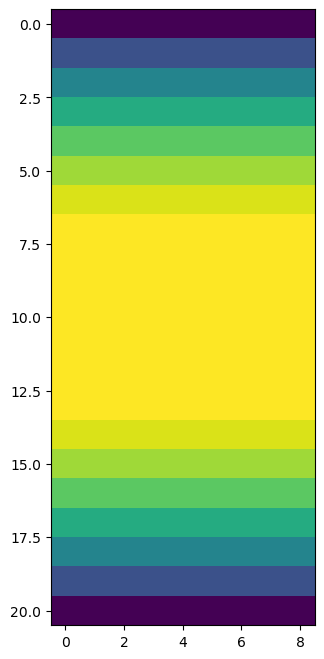

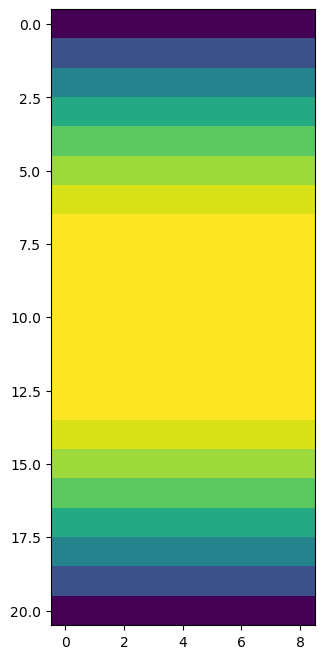

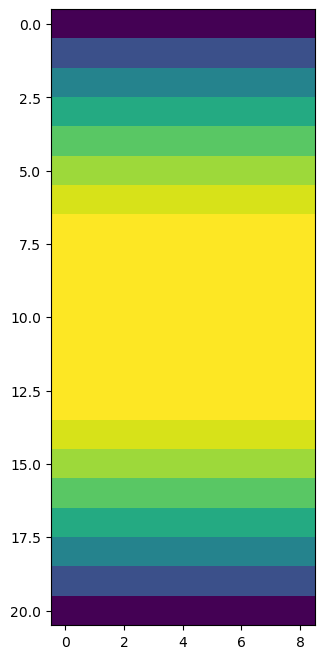

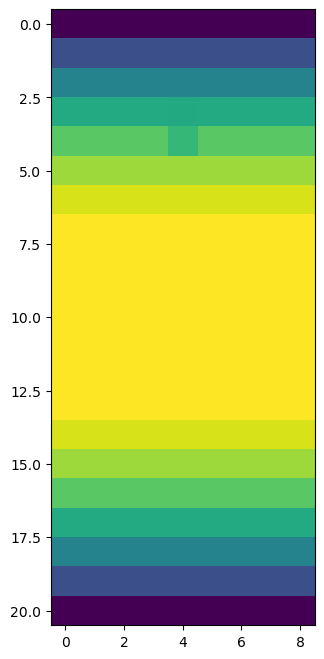

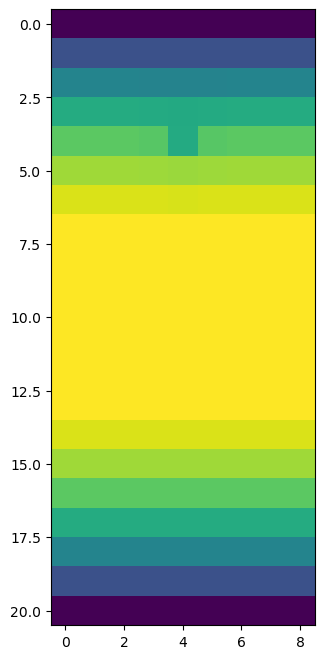

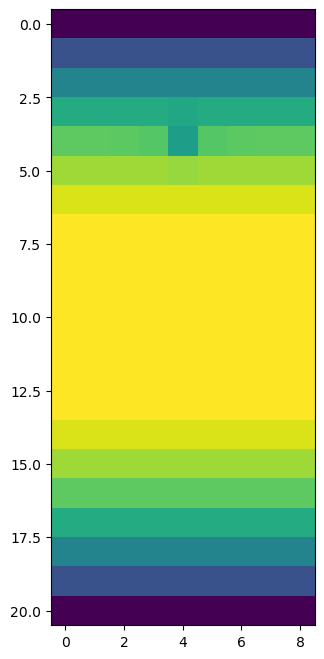

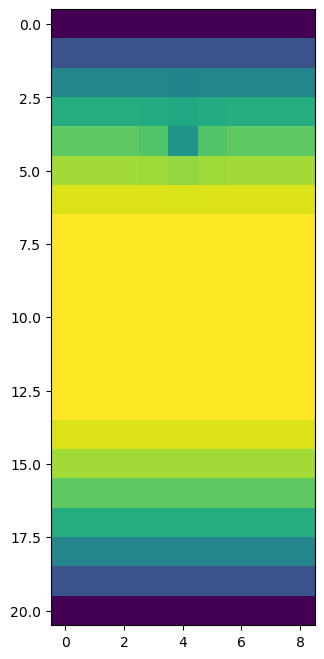

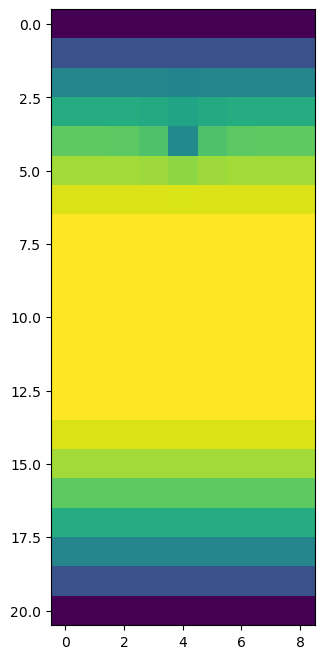

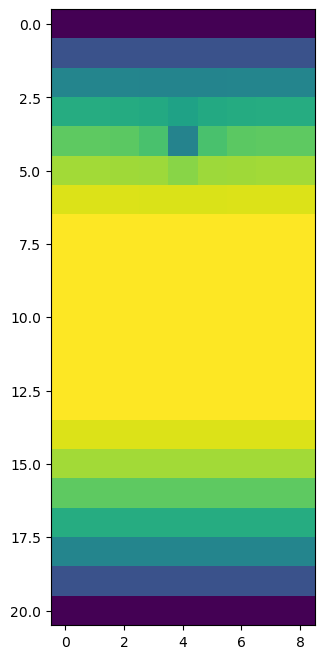

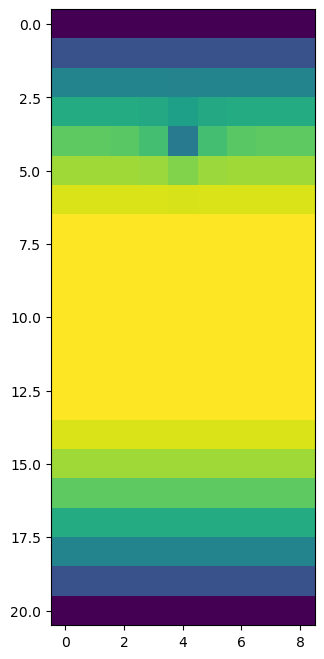

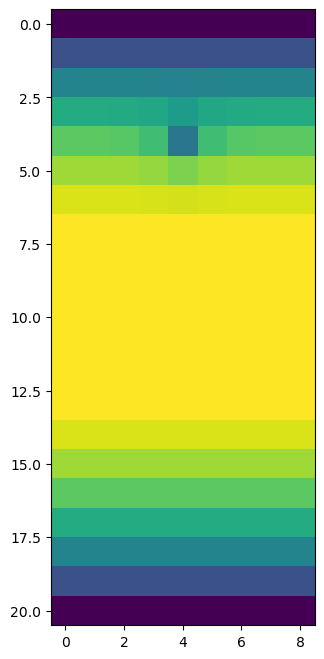

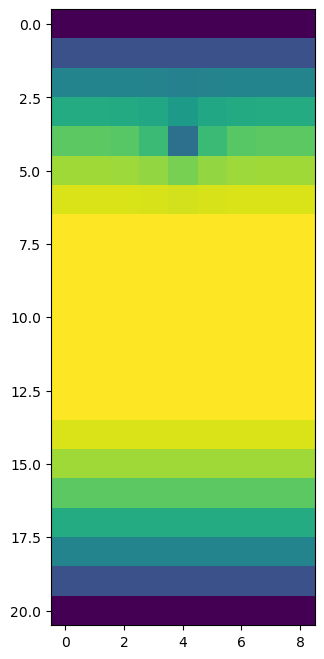

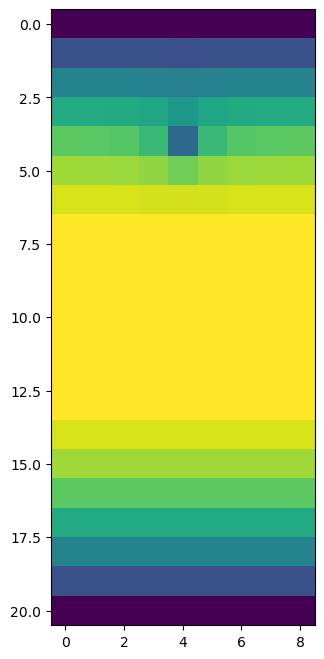

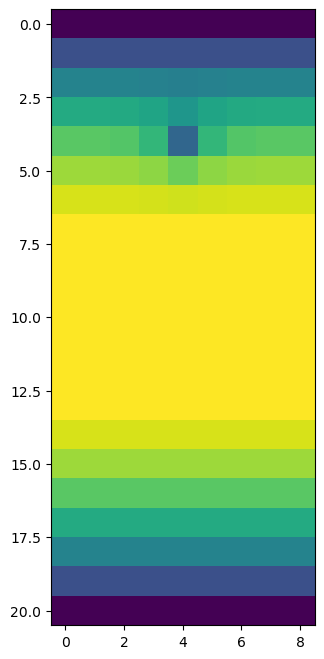

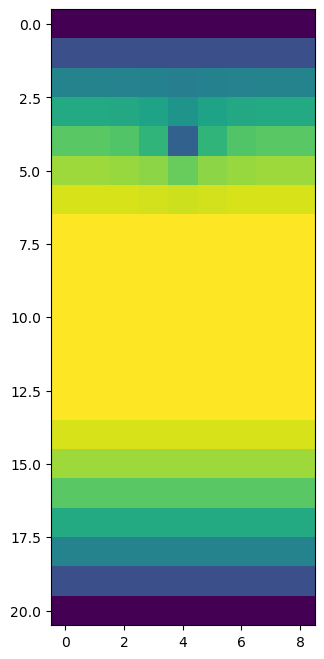

In [12]:
for i, (ts, sp) in enumerate(hds.get_kstpkper()):
    if ts == 7:
        f, ax = plt.subplots(1,1,figsize=(4,8), dpi=100)
        ax.imshow(hds.get_data(kstpkper=(ts, sp))[0], vmin=1000, vmax=1010)

#### instantiate a cell-by-cell budget output object

In [13]:
cbc = m.output.budget()

#### grab the info saved in the CBC output for the WEL and RCH packages

In [14]:
wel = cbc.get_data(text='wel', full3D=True)[-1].sum(axis=0)

In [15]:
rch = cbc.get_data(text='rch', full3D=True)

## create a fancy plot of simulated head contours

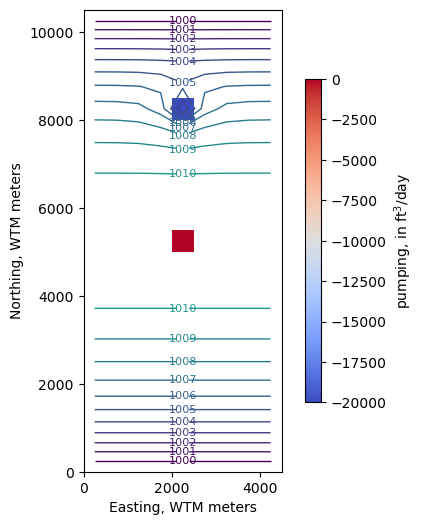

In [16]:
levels=np.arange(1000, 1020, 1)
wt = hds.get_data()
fig, ax = plt.subplots(figsize=(6, 6))
pmv = flopy.plot.PlotMapView(m, ax=ax)
ctr = pmv.contour_array(wt, levels=levels, 
                        linewidths=1, cmap='viridis')
labels = pmv.ax.clabel(ctr, inline=True, fontsize=8, inline_spacing=1)
vmin, vmax = -20000, 0
im = pmv.plot_array(wel, cmap='coolwarm', vmin=vmin, vmax=vmax)
cb = fig.colorbar(im, shrink=0.7, label='pumping, in ft$^3$/day')
ax.set_ylabel("Northing, WTM meters")
ax.set_xlabel("Easting, WTM meters")
ax.set_aspect(1)

#### pull a time-series of simulated heads at a specific model cell and plot

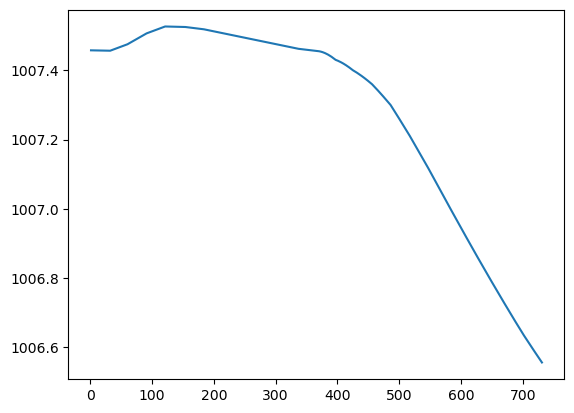

In [17]:
ts = hds.get_ts((0, 4, 3))
plt.plot(ts[:, 0], ts[:, 1])

## Try modifying a model property and rewrite the input files and run the model

#### the model object "m" has a child object "npf" which has an attribute "k" which has an attribute "data" which is a 3D array of horizontal hydraulic conductivity in each model cell

In [18]:
m.npf.k.data

array([[[50., 50., 50., 50., 50., 50., 50., 50., 50.],
        [50., 50., 50., 50., 50., 50., 50., 50., 50.],
        [50., 50., 50., 50., 50., 50., 50., 50., 50.],
        [50., 50., 50., 50., 50., 50., 50., 50., 50.],
        [50., 50., 50., 50., 50., 50., 50., 50., 50.],
        [50., 50., 50., 50., 50., 50., 50., 50., 50.],
        [50., 50., 50., 50., 50., 50., 50., 50., 50.],
        [50., 50., 50., 50., 50., 50., 50., 50., 50.],
        [50., 50., 50., 50., 50., 50., 50., 50., 50.],
        [50., 50., 50., 50., 50., 50., 50., 50., 50.],
        [50., 50., 50., 50., 50., 50., 50., 50., 50.],
        [50., 50., 50., 50., 50., 50., 50., 50., 50.],
        [50., 50., 50., 50., 50., 50., 50., 50., 50.],
        [50., 50., 50., 50., 50., 50., 50., 50., 50.],
        [50., 50., 50., 50., 50., 50., 50., 50., 50.],
        [50., 50., 50., 50., 50., 50., 50., 50., 50.],
        [50., 50., 50., 50., 50., 50., 50., 50., 50.],
        [50., 50., 50., 50., 50., 50., 50., 50., 50.],
        [5

#### change the hk value

In [19]:
m.npf.k = 25.

#### rewrite the NPF package input file

In [20]:
m.npf.write()

#### rerun the simulation

In [21]:
sim.run_simulation(silent=True)

(True, [])

#### grab the new output and compare to the original output

(1000.0, 1020.0)

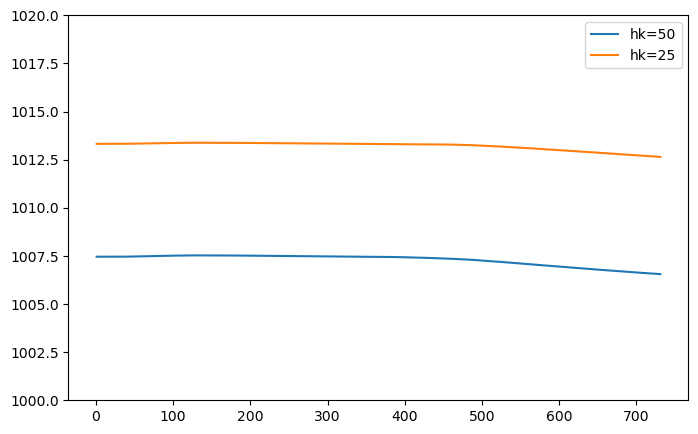

In [22]:
hds = m.output.head()
ts1 = hds.get_ts((0, 4, 3))
f, ax = plt.subplots(1,1,figsize=(8,5), dpi=100)
ax.plot(ts[:, 0], ts[:, 1], label="hk=50")
ax.plot(ts1[:, 0], ts1[:, 1], label="hk=25")
ax.legend(loc=1)
ax.set_ylim([1000, 1020])

## write a loop to try lots of values

#### save a timeseries of simulated head values from each to compare

In [23]:
hdsdict = {}
for kval in [25., 32., 39., 45., 50., 60., 70., 80., 100.]:
    m.npf.k = kval
    m.npf.write()
    sim.run_simulation(silent=True)
    hds = m.output.head()
    ts = hds.get_ts((0, 4, 3))
    hdsdict["hk{0}".format(kval)] = ts[:, 1]

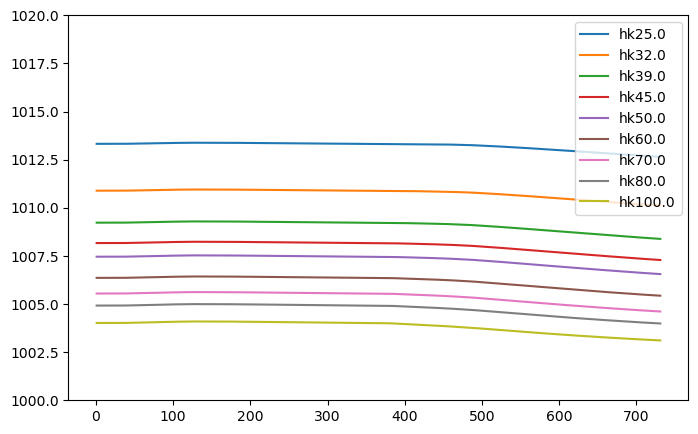

In [24]:
f, ax = plt.subplots(1,1,figsize=(8,5), dpi=100)
for hkval, ts in hdsdict.items():
    ax.plot(hds.get_times(), ts, label=hkval)
    ax.legend(loc=1)
    ax.set_ylim([1000, 1020])

#### reset to original value

In [25]:
m.npf.k = 50.

In [26]:
m.npf.write()

## now try the same heuristic exercise with recharge

In [27]:
spd = m.rch.recharge.get_data()
hdsdict1 = {}

for rfact in [.5, .62, .75, .87, 1., 1.25, 1.5, 1.75, 2.0]:
    print("running model with recharge modified by factor of {0}".format(rfact))
    spdi = {}
    for k, v in spd.items():
        if not v is None:
            spdi[k] = v * rfact
    m.rch.recharge.set_data(spdi)
    m.rch.write()
    sim.run_simulation(silent=True)
    hds = m.output.head()
    ts = hds.get_ts((0, 4, 3))
    hdsdict1["rch{0}".format(rfact)] = ts[:, 1]

# reset rch to original value
m.rch.recharge.set_data(spd)

running model with recharge modified by factor of 0.5
running model with recharge modified by factor of 0.62
running model with recharge modified by factor of 0.75
running model with recharge modified by factor of 0.87
running model with recharge modified by factor of 1.0
running model with recharge modified by factor of 1.25
running model with recharge modified by factor of 1.5
running model with recharge modified by factor of 1.75
running model with recharge modified by factor of 2.0


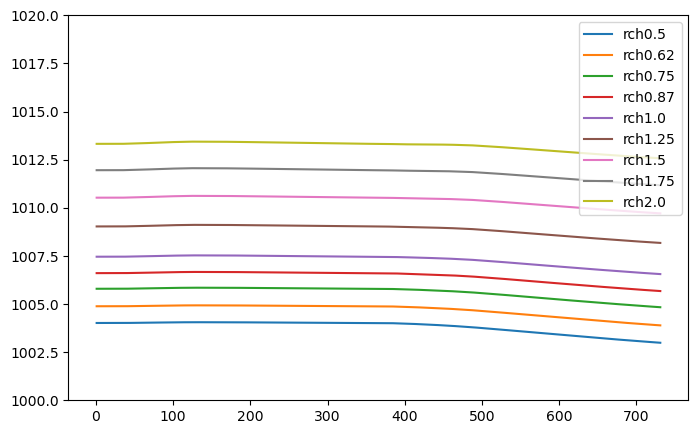

In [28]:
f, ax = plt.subplots(1,1,figsize=(8,5), dpi=100)
for rchval, ts in hdsdict1.items():
    ax.plot(hds.get_times(), ts, label=rchval)
    ax.legend(loc=1)
    ax.set_ylim([1000, 1020])

#### water use input (via WEL package) is a little more complicated than HK and RCH. Need to create a template object of the stress period data that we can modify and specify for each model re-write

In [29]:
wspd = m.wel.stress_period_data.get_data()

In [30]:
wspd

{0: rec.array([((0, 4, 4), 0., 0.), ((0, 10, 4), 0., 0.), ((0, 4, 4), 0., 0.)],
           dtype=[('cellid', 'O'), ('q', '<f8'), ('iface', '<f8')]),
 13: rec.array([((0, 4, 4), -20000., 0.), ((0, 10, 4),      0., 0.),
            ((0, 4, 4),      0., 0.)],
           dtype=[('cellid', 'O'), ('q', '<f8'), ('iface', '<f8')])}

In [31]:
q = -20000.
qfac = 1.
tpl_spd = {0: [((0, 4, 4), 0., 0.), ((0, 10, 4), 0., 0.), ((0, 4, 4), 0., 0.)],
           13:[((0, 4, 4), q * qfac, 0.), ((0, 10, 4), 0., 0.), ((0, 4, 4), 0., 0.)]}

In [32]:
tpl_spd

{0: [((0, 4, 4), 0.0, 0.0), ((0, 10, 4), 0.0, 0.0), ((0, 4, 4), 0.0, 0.0)],
 13: [((0, 4, 4), -20000.0, 0.0),
  ((0, 10, 4), 0.0, 0.0),
  ((0, 4, 4), 0.0, 0.0)]}

In [33]:
hdsdict2 = {}
for qfac in [.5, .62, .75, .87, 1., 1.25, 1.5, 1.75, 2.0]:
    print("running model with pumping modified by factor of {0}".format(qfac))
    tpl_spd = {0: [((0, 4, 4), 0., 0.), ((0, 10, 4), 0., 0.), ((0, 4, 4), 0., 0.)],
           13:[((0, 4, 4), q * qfac, 0.), ((0, 10, 4), 0., 0.), ((0, 4, 4), 0., 0.)]}
    m.wel.stress_period_data.set_data(tpl_spd)
    m.wel.write()
    sim.run_simulation(silent=True)
    hds = m.output.head()
    ts = hds.get_ts((0, 4, 3))
    hdsdict2["wel{0}".format(qfac)] = ts[:, 1]

running model with pumping modified by factor of 0.5
running model with pumping modified by factor of 0.62
running model with pumping modified by factor of 0.75
running model with pumping modified by factor of 0.87
running model with pumping modified by factor of 1.0
running model with pumping modified by factor of 1.25
running model with pumping modified by factor of 1.5
running model with pumping modified by factor of 1.75
running model with pumping modified by factor of 2.0


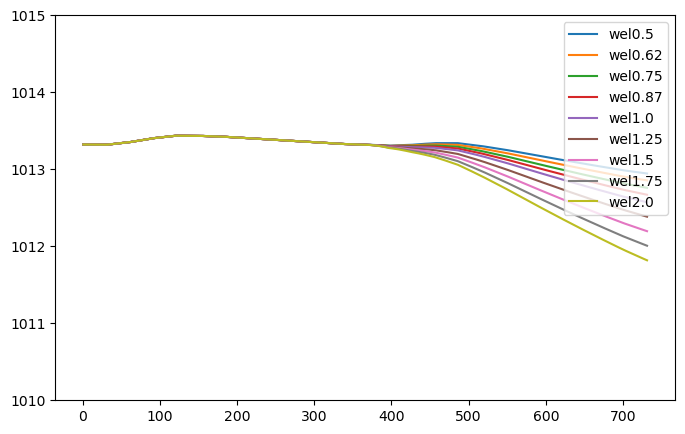

In [34]:
f, ax = plt.subplots(1,1,figsize=(8,5), dpi=100)
for rchval, ts in hdsdict2.items():
    ax.plot(hds.get_times(), ts, label=rchval)
    ax.legend(loc=1)
    ax.set_ylim([1010, 1015])

#### reset to original pumping rate

In [35]:
qfac = 1.0
tpl_spd = {0: [((0, 4, 4), 0., 0.), ((0, 10, 4), 0., 0.), ((0, 4, 4), 0., 0.)],
       13:[((0, 4, 4), q * qfac, 0.), ((0, 10, 4), 0., 0.), ((0, 4, 4), 0., 0.)]}
m.wel.stress_period_data.set_data(tpl_spd)
m.wel.write()
sim.run_simulation(silent=True)
hds = m.output.head()

In [36]:
hds = m.output.head()

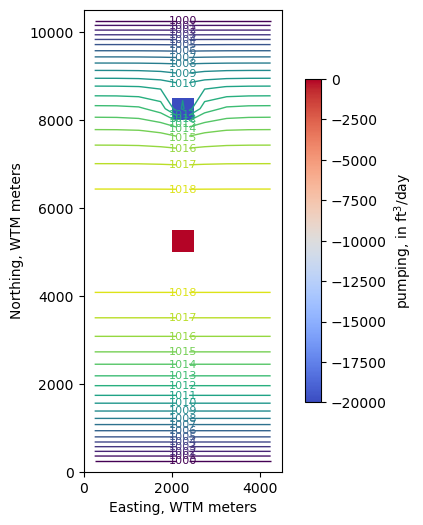

In [37]:
levels=np.arange(1000, 1020, 1)
wt = hds.get_data()
fig, ax = plt.subplots(figsize=(6, 6))
pmv = flopy.plot.PlotMapView(m, ax=ax)
ctr = pmv.contour_array(wt, levels=levels, 
                        linewidths=1, cmap='viridis')
labels = pmv.ax.clabel(ctr, inline=True, fontsize=8, inline_spacing=1)
vmin, vmax = -20000, 0
im = pmv.plot_array(wel, cmap='coolwarm', vmin=vmin, vmax=vmax)
cb = fig.colorbar(im, shrink=0.7, label='pumping, in ft$^3$/day')
ax.set_ylabel("Northing, WTM meters")
ax.set_xlabel("Easting, WTM meters")
ax.set_aspect(1)

In [38]:
m.set_all_data_external()
sim.write_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package mumodel...
  writing model mumodel...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package sto...
    writing package oc...
    writing package wel-1...
    writing package rch-1...
    writing package chd-from-ibound...
    writing package obs_0...
